<!-- %%HTML
<link rel="stylesheet" type="text/css" href="custom.css"> -->

In [1]:
# from IPython.display import Image, HTML

# # Load and publish CSS
# style = HTML('<link rel="stylesheet" type="text/css" href="custom.css">')

# display(style)

![IBSim-4i 2021](https://cdn.eventsforce.net/files/ef-q5vmtsq56tk6/website/1653/banner-2.jpg)

# Optimisation and Simulation of X-ray images: Automatic registration of surface models on synchrotron microtomography data

## Franck P. Vidal, Iwan T. Mitchell, and Jean Michel  Létang

<div id="thumbs">
    <a href="https://www.bangor.ac.uk/"><img src="A1_FullColour.png" alt="" width="150"/></a>
    <a href="https://www.insa-lyon.fr/en/"><img src="logo-version1.jpg" alt="" width="150"/></a>
<!--     <a href="https://www.centreleonberard.fr/en"><img src="Logo-centre-leon-berard-lyon.JPG" alt="" width="150"/></a> -->
    <span class="stretch"></span>
</div>

# Acknowledgements

- **Jean-Yves Buffière** and **Ce Xiao** of MATEIS laboratory (Lyon), and **Wolfgang Ludwig** of ESRF (Grenoble) for the new projection and CT data,
- **NVIDIA Corporation** for the donation of the NVIDIA TITAN Xp GPU used in the development and validation of gVirtualXRay, 
- **Supercomputing Wales** for the use of its supercomputer, and
- **All the volunteers** who participated to the user study.

# Motivations

      
- The presence of **strong imaging artefacts** in **microtomographic X-ray** data makes the **CAD modelling process difficult** to carry out. 
- A **user study** was conducted to **manually extract geometrical properties** from the CT slice.
- As an alternative to **manual measurements** and **traditional image segmentation techniques**, we proposed to **register CAD models** by deploying a realistic **X-ray simulation on GPU** in an **optimisation** framework. 

# Context: Artefacts in CT

![Typical example of a reconstructed slice from a fibre composite where strong CT artefacts are present](figure_01.svg)

## Two kinds of artefacts are clearly visible

- Black and white fringes at the silicon carbide edges: these phase artefacts are similar to some image enhancement techniques like unsharp masking and can be modelled by an additive term involving the Laplacian of the phase shift;
 - Dark streaks with bright borders, located along alignments of high density tungsten cores: these artefacts are due to beam hardening and the impulse response of the detector. As voxel values in these streaks are darker than what they should be, it means that the linear attenuation coefficients are underestimated in the artefact areas. 

# Linear attenuation coefficients (&mu;) in cm<sup>-1</sup>

## from the literature (Theoretical), and from the CT slice of the experiment at ESRF (Experimental)

| Structure | Material     | Theoretical | Experimental |
|-----------------|------------------|--------------------|----------------|
| Core         |  W               |   341.61       | 162.34&plusmn;21.67 |
| Fibre         |  SiC            |   2.74            | 5.61&plusmn;5.73  |
| Matrix      | Ti90Al6V4 |   13.13          | 12.87&plusmn;3.57 |

- **W** &mu; are underestimated by a factor of **2**,
- **SiC** coefficients are overestimated by a factor of **2**, and
- **Ti90Al6V4** coefficients are right.

# Image registration as an optimisation algorithm

![](figure_03.svg)

1. CAD models of the scanned object are generated
2. A CT acquisition is simulated to create X-ray projections from the CAD models
3. Simulated  X-ray projections are compared with the projections from the real experiments
4. An optimisation algorithm tweaks the parameters of the simulation models (CAD & CT acquisition) until convergence

**We need a quick way to simulate realistic X-ray projections.** 

# In a Nutshell

- Our implementation relies on open source software only. 
- We numerically modelled the real experiment, taking into account geometrical properties as well as beam hardening, impulse response of the detector, phase contrast, and photon noise. 
- Parameters of the overall model are then optimised so that X-ray projections of the registered the CAD models match the projections from an actual experiment. 

![](https://ibsim.co.uk/events/wp-content/uploads/2020/09/Slide12-1.png)

In [66]:
%matplotlib inline

import copy
import glob
import math
import os
# import sys
import base64

import cma
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import SimpleITK as sitk
from tifffile import imread, imsave
import tomopy

from matplotlib import cm
# from mpl_toolkits import mplot3d
from scipy import ndimage
from skimage.metrics import structural_similarity as ssim
from skimage.util import compare_images
from sklearn.metrics import mean_absolute_error, mean_squared_error

# from stl import mesh
# import k3d

# # plt.ioff()
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# plt.rcParams['font.size'] = 15

import gvxrPython3 as gvxr

from lsf import *

# Registration pipeline: Divide and Conquert

![](graphical_abstract.png)

In [3]:
NoneType = type(None);
pixel_spacing_in_micrometre = 1.9;
pixel_spacing_in_mm = pixel_spacing_in_micrometre * 1e-3;
number_of_projections = 900;
angular_span_in_degrees = 180.0;
angular_step = angular_span_in_degrees / number_of_projections;
theta = np.linspace(0.,
                    angular_span_in_degrees,
                    number_of_projections,
                    endpoint=False);
theta_rad = theta / 180.0 * math.pi;

In [4]:
# Load the image data

# Target of the registration
reference_normalised_projections = np.fromfile("../data/sino.raw", dtype=np.float32);
reference_normalised_projections.shape = [
    number_of_projections,
    int(reference_normalised_projections.shape[0] / number_of_projections)
];

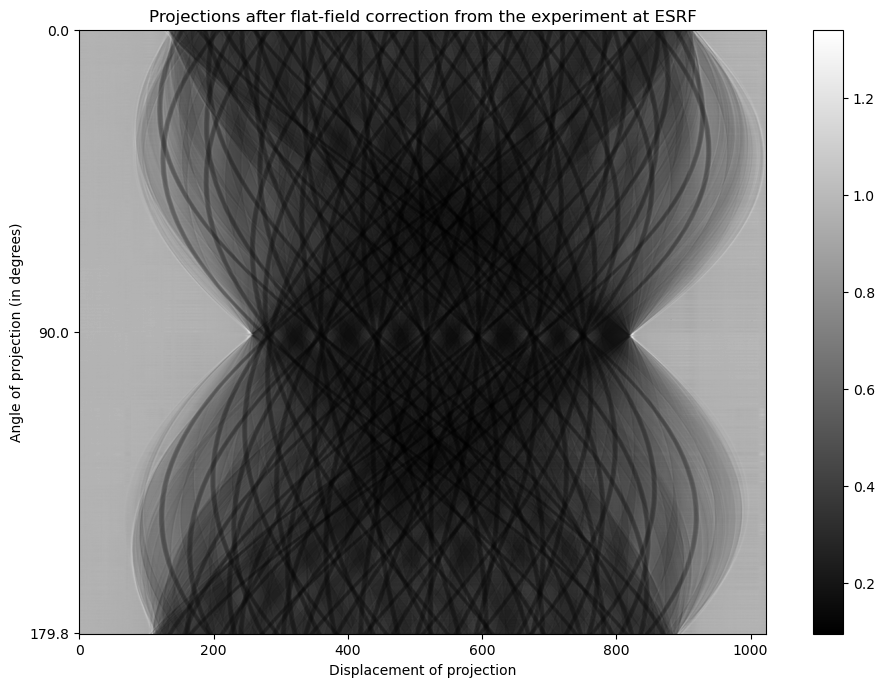

In [67]:
labels = [theta[0], theta[reference_normalised_projections.shape[0] // 2], theta[-1]];
tics = [
    0,
    reference_normalised_projections.shape[0] // 2,
    reference_normalised_projections.shape[0]-1
];
fig = plt.figure();
imgplot = plt.imshow(reference_normalised_projections, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Projections after flat-field correction from the experiment at ESRF");
fig.colorbar(imgplot);

In [14]:
def computeSinogramFromFlatField(normalised_projections):
    """
    This function apply the minus log normalisation
    on the projections that bave been corrected with the flat-field method.

    :param 2D_image normalised_projections: The projections after flat-field corrections
    :return the sinogram.
    """

    # Create a temporary image to hold the sinogram
    simulated_sinogram = copy.deepcopy(normalised_projections);

    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
#     threshold = 0.000001
#     simulated_sinogram[simulated_sinogram < threshold] = threshold;

#     # Apply the minus log normalisation
#     simulated_sinogram = -np.log(simulated_sinogram);

    simulated_sinogram = tomopy.minus_log(simulated_sinogram)


    # Rescale the data taking into account the pixel size
    simulated_sinogram /= pixel_spacing_in_micrometre * gvxr.getUnitOfLength("um") / gvxr.getUnitOfLength("cm");

    # Return the new image
    return simulated_sinogram;

In [15]:
# Compute the sinogram from the flat-field data

reference_sinogram = computeSinogramFromFlatField(reference_normalised_projections);

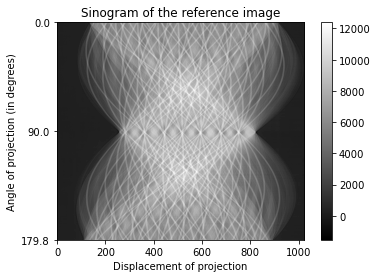

In [16]:
labels=[theta[0], theta[reference_sinogram.shape[0] // 2], theta[-1]];
tics=[0, reference_sinogram.shape[0] // 2, reference_sinogram.shape[0]-1];
fig=plt.figure();
imgplot = plt.imshow(reference_sinogram, cmap="gray");
plt.xlabel("Displacement of projection");
plt.ylabel("Angle of projection (in degrees)");
plt.yticks(tics, labels);
plt.title("Sinogram of the reference image");
fig.colorbar(imgplot);


In [22]:
# CT reconstruction

reference_sinogram.shape = [
    reference_sinogram.shape[0],
    1,
    reference_sinogram.shape[1]
];

rot_center = int(reference_sinogram.shape[2]/2);

reference_CT = tomopy.recon(reference_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp')[0];

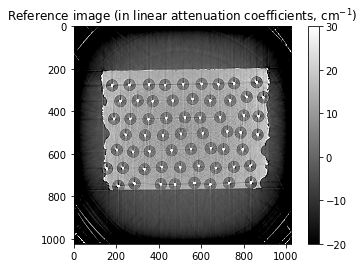

In [23]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=30, vmin=-20)
imgplot = plt.imshow(reference_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Reference image (in linear attenuation coefficients, cm$^{-1}$)");

Sino or Proj?

In [24]:
use_sinogram = True

Image comparison method

In [25]:
def standardisation(I):
    image = copy.deepcopy(I);

    # Sometimes the CT reconstruction algorithm create NaN on
    # the top and right borders, we filter them out using
    # a median filter ignoring NaN
    nan_index = np.argwhere(np.isnan(image));
    if nan_index.shape[0]:
        temp = np.pad(image, 1, "edge");

        for index in nan_index:
            roi = temp[index[0]-1+1:index[0]+1+2, index[1]-1+1:index[1]+1+2];
            image[index[0], index[1]] = np.nanmedian(roi);

    return (image - image.mean()) / image.std();

In [26]:
normalised_reference_sinogram = standardisation(reference_sinogram);
normalised_reference_CT       = standardisation(reference_CT);

In [27]:
def metrics(ref, test):

    normalised_ref = ref.flatten();
    normalised_test = test.flatten();

    if use_normalisation or metrics_type == "ZNCC":
        normalised_ref = standardisation(normalised_ref);
        normalised_test = standardisation(normalised_test);

    # Mean absolute error
    if metrics_type == "MAE":
        return mean_absolute_error(normalised_ref, normalised_test);
    # RMSE
    elif metrics_type == "RMSE":
        return math.sqrt(mean_squared_error(normalised_ref, normalised_test));
    # Mean relative error
    elif metrics_type == "MRE" or metrics_type == "MAPE":

        # Prevent division by zero
        denominator = np.abs(np.subtract(normalised_ref, normalised_test)) + 1e-6;
        divisor = np.abs(normalised_ref) + 1e-6;

        return np.mean(np.divide(denominator, divisor));
    elif metrics_type == "SSIM" or metrics_type == "DSSIM":
        normalised_ref.shape = [900, 1024];
        normalised_test.shape = [900, 1024];
        return (1.0 - ssim(normalised_ref, normalised_test,
                  data_range=normalised_ref.max() - normalised_ref.min())) / 2.0;
    elif metrics_type == "ZNCC":
        return (1.0 - np.mean(np.multiply(normalised_ref, normalised_test))) / 2.0;
    else:
        raise "Unknown metrics";

In [28]:
metrics_type = "RMSE"
use_normalisation = True

# Generate CAD models

# Find circles to identify the centre of fibres

We can use the Hoguh transform to detect where circles are in the image. However, the input image in OpenCV's function must be in UINT. We blur it using a bilateral filter (an edge-preserving smoothing filter).

In [29]:
fibre_radius = 140 / 2;  # um
core_radius = 30 / 2;  # um

fibre_material = [("Si", 0.5), ("C", 0.5)];
fibre_mu = 2.736; # cm-1
fibre_density = 3.2; # g/cm3

core_material = [("W", 1)];
core_mu = 341.61; # cm-1
core_density = 19.3 # g/cm3

matrix_material = [("Ti", 0.9), ("Al", 0.06), ("V", 0.04)];
matrix_mu = 13.1274; # cm-1
matrix_density = 4.42 # g/cm3


In [30]:
def float2uint8(anImage, min_threshold = None, max_threshold = None):
    
    uchar_image = copy.deepcopy(anImage);

    if isinstance(min_threshold, NoneType):
        min_threshold = np.min(uchar_image);

    if isinstance(max_threshold, NoneType):
        max_threshold = np.max(uchar_image);
        
    uchar_image[uchar_image < min_threshold] = min_threshold;
    uchar_image[uchar_image > max_threshold] = max_threshold;

    uchar_image -= min_threshold;
    uchar_image /= max_threshold - min_threshold;
    uchar_image *= 255;
    
    return uchar_image.astype(np.uint8);

In [31]:
uint8_reference_CT = float2uint8(reference_CT, 0, 300);
blurred_reference_CT = cv2.bilateralFilter(uint8_reference_CT, 9, 75, 75);

circles = cv2.HoughCircles(blurred_reference_CT, cv2.HOUGH_GRADIENT, 2, 80,
                            param1=150, param2=5, minRadius=5, maxRadius=15);

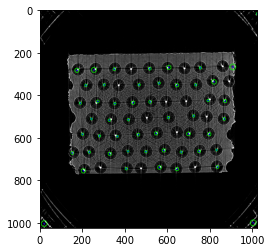

In [32]:
cimg = cv2.cvtColor(float2uint8(reference_CT, 0, 50), cv2.COLOR_GRAY2BGR);
circles = np.uint16(np.around(circles));

for i in circles[0,:]:
    
    # draw the outer circle
    cv2.circle(cimg, (i[0], i[1]), i[2], (0, 255, 0), 2);
    
    # draw the center of the circle
    cv2.circle(cimg, (i[0], i[1]), 2, (0, 0, 255), 3);
    
fig=plt.figure();
imgplot = plt.imshow(cimg);

13 fibres were missed and many centres were misplaced. Controlling the meta-parameters of the algorithm can be difficult to employ in a fully-automatic registration framework. We will use another technique to register the fibres, the popular Otsu's method. It creates a histogram and uses a heuristic to determine a threshold value.

In [33]:
# Convert the numpy array in float32 into uint, then into a SITK image
volume = sitk.GetImageFromArray(blurred_reference_CT);
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

# Apply the Otsu's method
otsu_filter = sitk.OtsuThresholdImageFilter();
otsu_filter.SetInsideValue(0);
otsu_filter.SetOutsideValue(1);
seg = otsu_filter.Execute(volume);

# Print the corresponding threshold
print("Threshold:", otsu_filter.GetThreshold());

Threshold: 91.0


In [34]:
# Clean-up using mathematical morphology
cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(seg, [3, 3, 3])
cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [3, 3, 3])

In [35]:
# Mark each potential tungsten core with unique label

core_labels = sitk.ConnectedComponent(cleaned_thresh_img);

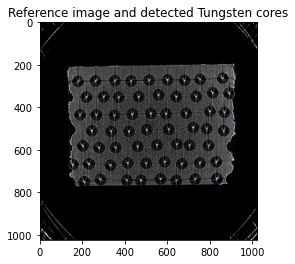

In [36]:
fig = plt.figure();

volume = sitk.GetImageFromArray(float2uint8(reference_CT, 0, 50));
volume.SetSpacing([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm]);

imgplot = plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(volume, core_labels)));
plt.title("Reference image and detected Tungsten cores");

In [37]:
# Get the centroid

shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(core_labels)

centroid_set = [];

for i in shape_stats.GetLabels():
    centroid_set.append(cleaned_thresh_img.TransformPhysicalPointToIndex(shape_stats.GetCentroid(i)));


In [38]:
def setFibres(aCentroidSet):
    """This function loads a cylinders in the GPU memory.
    Some are hollow and represent the fibres, some are not and
    correspond to the cores.

    :param array aCentroidSet: a list of cylinder centres.
    """

    global core_radius;
    global fibre_radius;

    # Create empty geometries
    gvxr.emptyMesh("fibre");
    gvxr.emptyMesh("core");

    # Number of sectors to approximate cylinders with triangle meshes
    # It controls the accuracy of the meshes.
    number_of_sectors = 100;

    # Process all the centres from the input list
    for i, cyl in enumerate(aCentroidSet):

        # Convert the centre position from 2D image coordinates in 3D world coordinates
        x = pixel_spacing_in_micrometre * -(cyl[0] - reference_CT.shape[1] / 2 + 0.5);
        y = pixel_spacing_in_micrometre * (cyl[1] - reference_CT.shape[0] / 2 + 0.5);

        # Create empty geometries (is it needed?)
        gvxr.emptyMesh("fibre_" + str(i));
        gvxr.emptyMesh("core_" + str(i));

        # Create the two corresponding cylinders (fibre and core)
        gvxr.makeCylinder("fibre_" + str(i), number_of_sectors, 815.0, fibre_radius, "micrometer");
        gvxr.makeCylinder("core_"  + str(i), number_of_sectors, 815.0,  core_radius, "micrometer");

        # Translate the two cylinders to the position of their centre
        gvxr.translateNode("fibre_" + str(i), y, 0.0, x, "micrometer");
        gvxr.translateNode("core_" + str(i), y, 0.0, x, "micrometer");

        # Apply the local transformation matrix (so that we could save the corresponding STL files)
        gvxr.applyCurrentLocalTransformation("fibre_" + str(i));
        gvxr.applyCurrentLocalTransformation("core_" + str(i));

        # Subtract the fibre from the matrix
        gvxr.subtractMesh("matrix", "fibre_" + str(i));

        # Subtract the core from the fibre
        gvxr.subtractMesh("fibre_" + str(i), "core_" + str(i));

        # Save the corresponding STL files
        # gvxr.saveSTLfile("fibre_" + str(i), "Tutorial2/outputs/fibre_" + str(i) + ".stl");
        # gvxr.saveSTLfile("core_" + str(i),  "Tutorial2/outputs/core_"  + str(i) + ".stl");

        # Add the mesh of the current fibre to the overall fibre mesh
        gvxr.addMesh("fibre", "fibre_" + str(i));

        # Add the mesh of the current core to the overall core mesh
        gvxr.addMesh("core", "core_"  + str(i));

    # Set the mesh colours (for the interactive visualisation)
    gvxr.setColor("fibre", 1.0, 0.0, 0.0, 1.0);
    gvxr.setColor("core",  1.0, 0.0, 1.0, 1.0);

    # Set the fibre's material properties
    # gvxr.setLinearAttenuationCoefficient("fibre", fibre_mu, "cm-1");
    gvxr.setCompound("fibre", "SiC");
    gvxr.setDensity("fibre", fibre_density, "g/cm3");

    # Set the core's material properties
    # gvxr.setLinearAttenuationCoefficient("core", core_mu, "cm-1");
    gvxr.setElement("core", "W");

    # Add the fibres and cores to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("core");
    gvxr.addPolygonMeshAsInnerSurface("fibre");

In [39]:
def setMatrix(apGeneSet):
    """This function loads a cube in the GPU memory. The cube represents
    the Ti90Al6V4 matrix.

    apGeneSet[0] is a number between -0.5 and 0.5, related to the translation vector (X component) of the cube. It can be interpreted as a percentage of the detector width.
    apGeneSet[1] is the same as apGeneSet[0], but related to the Y component of the translation vector.
    apGeneSet[2] is a number between -0.5 and 0.5, related to the rotation angle in degrees
    apGeneSet[3] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of the detector width.
    apGeneSet[4] is a scaling factor between -0.5 and 0.5. It can be interpreted as a percentage of apGeneSet[3].
    """

    # Remove all the geometries from the whole scenegraph
    gvxr.removePolygonMeshesFromSceneGraph();

    # Make a cube
    gvxr.makeCube("matrix", 1.0, "micrometer");

    # Translation vector
    x = apGeneSet[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    y = apGeneSet[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;
    gvxr.translateNode("matrix", x, 0.0, y, "micrometer");

    # Rotation angle
    rotation_angle_in_degrees = (apGeneSet[2] + 0.5) * 180.0;
    gvxr.rotateNode("matrix", rotation_angle_in_degrees, 0, 1, 0);

    # Scaling factors
    w = (apGeneSet[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
    h = (apGeneSet[4] + 0.5) * w;
    gvxr.scaleNode("matrix", w, 815, h);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("matrix");

    # Set the matrix's material properties
    gvxr.setMixture("matrix", "Ti90Al6V4");
    gvxr.setDensity("matrix", matrix_density, "g/cm3");

    # Add the matrix to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("matrix");

# Simulate a CT acquisition

in the same conditions as the real acquisition

# Experimental set up at ESRF's ID19 - Microtomography beamline

![](figure_05.svg)

In [40]:
# Set the X-ray simulation environment

# First we create an OpenGL context, here using EGL, i.e. no window.

gvxr.createWindow(0, 1, "EGL");
gvxr.setWindowSize(512, 512);


In [41]:
# We set the parameters of the X-ray detector (flat pannel), e.g. number of pixels, pixel, spacing, position and orientation:

detector_width_in_pixels = reference_normalised_projections.shape[1];
detector_height_in_pixels = 1;
distance_object_detector_in_m =    0.08; # = 80 mm

gvxr.setDetectorPosition(-distance_object_detector_in_m, 0.0, 0.0, "m");
gvxr.setDetectorUpVector(0, 1, 0);
gvxr.setDetectorNumberOfPixels(detector_width_in_pixels, detector_height_in_pixels);
gvxr.setDetectorPixelSize(pixel_spacing_in_micrometre, pixel_spacing_in_micrometre, "micrometer");

lsf_kernel = None

In [42]:
# And the source parameters (beam shape, source position)

distance_source_detector_in_m  = 145.0;

gvxr.setSourcePosition(distance_source_detector_in_m - distance_object_detector_in_m,  0.0, 0.0, "m");
gvxr.usePointSource();

bias = None
gain = None
scale = None

In [43]:
def tomographyAcquisition():
    """
    This function simulate a CT acquisition.

    :return the raw projections in keV
    """

    # Crete a new array to save every projection in default unit of energy
    raw_projections = [];

    # For each angle, simulate a projection
    for angle_id in range(0, number_of_projections):

        # Reset the transformation matrix and rotate the scnned object
        gvxr.resetSceneTransformation();
        gvxr.rotateScene(-angular_step * angle_id, 0, 1, 0);

        # Compute the X-ray image
        xray_image = np.array(gvxr.computeXRayImage());

        # Add the projection
        raw_projections.append(xray_image);

    # Convert from the default unit of energy to keV
    raw_projections = np.array(raw_projections);
    raw_projections_in_keV = raw_projections / gvxr.getUnitOfEnergy("keV");

    return raw_projections_in_keV;

In [44]:
def flatFieldCorrection(raw_projections_in_keV):
    """
    This function applies the flat-field correction on raw projections.

    :param 2D_image raw_projections_in_keV: the raw X-ray projections in keV
    :return the projections (raw_projections_in_keV) after flat-field correction
    """

    # Create a mock dark field image
    dark_field_image = np.zeros(raw_projections_in_keV.shape);

    # Create a mock flat field image
    flat_field_image = np.ones(raw_projections_in_keV.shape);

    # Retrieve the total energy
    total_energy = 0.0;
    energy_bins = gvxr.getEnergyBins("keV");
    photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

    for energy, count in zip(energy_bins, photon_count_per_bin):
        total_energy += energy * count;
    flat_field_image *= total_energy;

    # Apply the actual flat-field correction on the raw projections
    corrected_projections = (raw_projections_in_keV - dark_field_image) / (flat_field_image - dark_field_image);

    return corrected_projections;

In [45]:
def simulateSinogram(sigma_set=None, k_set=None, name_set=None):

    global lsf_kernel;

    # Do not simulate the phase contrast using a Laplacian
    if isinstance(sigma_set, NoneType) or isinstance(k_set, NoneType) or isinstance(name_set, NoneType):

        # Get the raw projections in keV
        raw_projections_in_keV = tomographyAcquisition();

    # Simulate the phase contrast using a Laplacian
    else:

        # Create the convolution filter
        pixel_range = np.linspace(-value_range, value_range, num=int(num_samples), endpoint=True)
        laplacian_kernels = {};

        # Store the L-buffers
        L_buffer_set = {};

        # Look at all the children of the root node
        for label in ["core", "fibre", "matrix"]:
            # Get its L-buffer
            L_buffer_set[label] = getLBuffer(label);

        # Create blank images
        raw_projections_in_keV = np.zeros(L_buffer_set["fibre"].shape);
        phase_contrast_image = np.zeros(L_buffer_set["fibre"].shape);

        for label, k, sigma in zip(name_set, k_set, sigma_set):
            laplacian_kernels[label] = k * laplacian(pixel_range, sigma);

            for z in range(phase_contrast_image.shape[0]):
                for y in range(phase_contrast_image.shape[1]):
                    phase_contrast_image[z][y] += ndimage.convolve((L_buffer_set[label])[z][y], laplacian_kernels[label], mode='wrap');

        for energy, photon_count in zip(gvxr.getEnergyBins("keV"), gvxr.getPhotonCountEnergyBins()):

            # Create a blank image
            attenuation = np.zeros(L_buffer_set["fibre"].shape);

            # Look at all the children of the root node
            # for label in ["core", "fibre", "matrix"]:
            for label in ["core", "fibre", "matrix"]:
                # Get mu for this object for this energy
                mu = gvxr.getLinearAttenuationCoefficient(label, energy, "keV");

                # Compute sum mu * x
                attenuation += L_buffer_set[label] * mu;

            # Store the projection for this energy channel
            raw_projections_in_keV += energy * photon_count * np.exp(-attenuation);

        # Apply the phase contrast
        raw_projections_in_keV -= phase_contrast_image;

    # Apply the LSF line by line
    if not isinstance(lsf_kernel, NoneType):
        for z in range(raw_projections_in_keV.shape[0]):
            for y in range(raw_projections_in_keV.shape[1]):
                raw_projections_in_keV[z][y] = ndimage.convolve(raw_projections_in_keV[z][y], lsf_kernel, mode='wrap');

    # Flat-field correction
    normalised_projections = flatFieldCorrection(raw_projections_in_keV);
    normalised_projections[normalised_projections < 0] = 0;

    # Add noise
    if not isinstance(bias, NoneType) and not isinstance(gain, NoneType) and not isinstance(scale, NoneType):

        map = (normalised_projections + (bias + 1)) * gain;
        temp = np.random.poisson(map).astype(float);
        temp /= gain;
        temp -= bias + 1;

        # Noise map
        noise_map = (normalised_projections - temp) * scale;
        normalised_projections += noise_map;

    # Linearise
    simulated_sinogram = computeSinogramFromFlatField(normalised_projections);

    return simulated_sinogram, normalised_projections, raw_projections_in_keV;

# Forward Modelling: Effective monochromatic attenuation

When the primary spectrum is not monochromatic the measurement in the equation above, $\boldsymbol{I}$ is the sum of several attenuation laws. We could however compute the effective monochromatic attenuation that would give the same measurement:
\begin{equation}
    \boldsymbol{I}(x,y) = \boldsymbol{I}_0(x,y) \; \exp\left({-\sum_j \mu_j(E_{\mathrm{eff}}) \; \boldsymbol{d}_j(x,y)}\right)
    \label{eq:beer2}
\end{equation}
which is the model considered by CT reconstruction algorithms. **1st source of issue in CT reconstructed images: beam hardening**

In [46]:
gvxr.addEnergyBinToSpectrum(33, "keV", 1.0);


# Register the cube

In [47]:
def fitnessFunctionCube(x):
    global best_fitness;
    global best_fitness_id;
    global prefix;

    global reference_sinogram;
    global centroid_set;
    global use_fibres;

    global core_radius;
    global fibre_radius;

    # Load the matrix geometrical properties from x
    setMatrix(x);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();
   
    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;

        gvxr.saveSTLfile("matrix", "outputs/matrix_" + str(best_fitness_id) + ".stl");

        # Reconstruct the CT slice
        simulated_CT = tomopy.recon(simulated_sinogram,
                                    theta_rad,
                                    center=rot_center,
                                    sinogram_order=False,
                                    algorithm='gridrec',
                                    filter_name='shepp',
                                    ncore=40)[0];

        # Save the simulated sinogram
        simulated_sinogram.shape = (simulated_sinogram.size // simulated_sinogram.shape[2], simulated_sinogram.shape[2]);
        imsave("outputs/" + prefix + "simulated_sinogram_" + str(best_fitness_id) + ".tif",
                simulated_sinogram.astype(np.single));

        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                simulated_CT.astype(np.single))

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;

    return objective

In [48]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/cube.dat"):
    matrix_geometry_parameters = np.loadtxt("outputs/cube.dat");
# Perform the registration using CMA-ES
else:
    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "cube_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = [5*[-0.5], 5*[0.5]];

    es = cma.CMAEvolutionStrategy([0.0, 0.0, 0.0, 0.256835938, 0.232903226], 0.5, opts);
    es.optimize(fitnessFunctionCube);

    matrix_geometry_parameters = copy.deepcopy(es.result.xbest);
    np.savetxt("outputs/cube.dat", matrix_geometry_parameters, header='x,y,rotation_angle,w,h');
    
    # Release memory
    del es;

# Apply the result of the registration

In [49]:
# Save the result
setMatrix(matrix_geometry_parameters);
gvxr.saveSTLfile("matrix", "outputs/matrix.stl");

# Translation vector
x = matrix_geometry_parameters[0] * detector_width_in_pixels * pixel_spacing_in_micrometre;
y = matrix_geometry_parameters[1] * detector_width_in_pixels * pixel_spacing_in_micrometre;

# Rotation angle
rotation_angle_in_degrees = (matrix_geometry_parameters[2] + 0.5) * 180.0;

# Scaling factors
w = (matrix_geometry_parameters[3] + 0.5) * detector_width_in_pixels * pixel_spacing_in_micrometre;
h = (matrix_geometry_parameters[4] + 0.5) * w;

print("Matrix");
print("\tposition:", x, y, "um");
print("\trotation:", rotation_angle_in_degrees, "deg");
print("\tsize:", w, h, "um");

Matrix
	position: -58.91101583843037 -27.89721420537629 um
	rotation: 92.7464036579993 deg
	size: 1413.8318440784685 1111.7402147391972 um


# Simulate the correspond CT acquisition

In [50]:
# Simulate a sinogram
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);

# Compute the ZNCC
print("ZNCC matrix registration:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

ZNCC matrix registration: 72.62


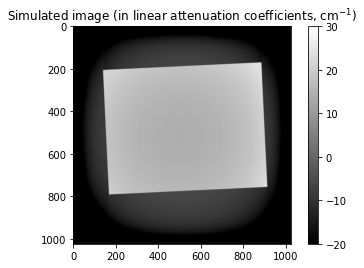

In [52]:
fig=plt.figure();
norm = cm.colors.Normalize(vmax=30, vmin=-20)
imgplot = plt.imshow(simulated_CT, cmap="gray", norm=norm);
fig.colorbar(imgplot);
plt.title("Simulated image (in linear attenuation coefficients, cm$^{-1}$)");

# Display the result of the registration as an animation

In [76]:
def createAnimation(aPrefix, anOutputFile):
    # Find all the images from the output directory
    files = sorted(
        glob.glob(aPrefix + "[0-9]*.tif"))

    # Store the images
    registration_image_set = [];

    # Create the GIF file
    with imageio.get_writer(anOutputFile, mode='I') as writer:

        # Store the PNG filenames
        png_filename_set = [];

        # Process all the images
        for i in range(len(files)):
            # Create the filenames
            mha_fname = aPrefix + str(i) + ".tif";
            png_filename_set.append(aPrefix + str(i) + ".png");
            
            # Open the MHA file
            narray = imread(mha_fname);

            offset = 60;
            roi_ref = reference_CT[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_sim = narray[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];

            narray = standardisation(narray);
            registration_image_set.append(narray);

            # Create the figure
            fig, axs = plt.subplots(3, 3)

            # Dispay the reference, registration and error map
            fig.suptitle('Registration: Result ' + str(i+1) + "/" + str(len(files)))
            plt.tight_layout();
            norm = cm.colors.Normalize(vmax=1.25, vmin=-0.5)

            comp_equalized = compare_images(normalised_reference_CT, narray, method='checkerboard');

            roi_normalised_ref = normalised_reference_CT[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_normalised_sim = narray[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];
            roi_normalised_compare = comp_equalized[505 - offset:505 + offset + 1,501 - offset:501 + offset + 1];


            # Reference
            axs[0, 0].set_title("Reference image");
            axs[0, 0].imshow(normalised_reference_CT, cmap="gray", norm=norm);
            axs[1, 0].imshow(roi_normalised_ref, cmap="gray", norm=norm);
            axs[2, 0].axis('off');

            # Registration
            axs[0, 1].set_title("Simulated CT slice after automatic registration");
            axs[0, 1].imshow(narray, cmap='gray', norm=norm);
            axs[1, 1].imshow(roi_normalised_sim, cmap="gray", norm=norm);

            y_ref = np.diag(roi_ref)
            y_test = np.diag(roi_sim)
            len_y = len(roi_ref)

            zero_offset = round(57.32 + (63.64 - 57.32) / 2.0)
            x = np.array(range(len_y)).astype(float)
            x -= zero_offset + 0.5
            x = x * math.sqrt(2.0 * pixel_spacing_in_micrometre * pixel_spacing_in_micrometre)

            axs[2, 1].set_title("Diagonal profiles");
            axs[2, 1].plot(x, y_ref, label="Reference");
            axs[2, 1].plot(x, y_test, label="Simulated");
            axs[2, 1].set_xlabel("Distance along profile (in $\mathrm{\mu}$m)")
            axs[2, 1].set_ylabel("Linear attenuation coefficients\n(in cm$^{-1}$)")
            # axs[2, 1].plot(np.diag(roi_ref) - np.diag(roi_sim), label="Error");
            axs[2, 1].legend();
    
            # Error map
            ZNCC = 100.0 * np.mean(np.multiply(normalised_reference_CT, narray));
            axs[0, 2].set_title("Checkboard comparison between\nthe reference and simulated images\nZNCC: " + "{:.2f}".format(ZNCC));
            axs[0, 2].imshow(comp_equalized, cmap='gray', norm=norm);
            axs[1, 2].imshow(roi_normalised_compare, cmap='gray', norm=norm);
            axs[2, 2].axis('off');

            plt.tight_layout();

            # Save the figure as a PNG file
            plt.savefig(png_filename_set[i])

            # Close the figure
            plt.close()

            # Open the PNG file with imageio and add it to the GIF file
            image = imageio.imread(png_filename_set[i])
            writer.append_data(image)

            # Delete the PNG file
            os.remove(png_filename_set[i]);

        for i in range(15):
            writer.append_data(image)

    return registration_image_set, image;

In [68]:
if not os.path.exists("outputs/cube_registration.gif"):
    cube_registration_image_set, image = createAnimation("outputs/cube_simulated_CT_",
                'outputs/cube_registration.gif');

![](./outputs/cube_registration.gif)

In [72]:
def fitnessFunctionFibres(x):
    global best_fitness;
    global best_fitness_id;
    global fibre_radius;
    global core_radius;
    global prefix;

    # Get the radii
    fibre_radius = x[0];
    core_radius = fibre_radius * x[1];

    # Load the matrix
    setMatrix(matrix_geometry_parameters);

    # Load the cores and fibres
    setFibres(centroid_set);

    # Simulate a sinogram
    simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

    # Compute the objective value
    if use_sinogram:
        objective = metrics(reference_sinogram, simulated_sinogram);
    else:
        objective = metrics(reference_normalised_projections, normalised_projections);

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        best_fitness = objective;
        
        gvxr.saveSTLfile("core",  "outputs/" + prefix + str(best_fitness_id) + "_cores.stl");
        gvxr.saveSTLfile("fibre", "outputs/" + prefix + str(best_fitness_id) + "_fibres.stl");
        
        # Reconstruct the CT slice
        simulated_CT = tomopy.recon(simulated_sinogram,
                                    theta_rad,
                                    center=rot_center,
                                    sinogram_order=False,
                                    algorithm='gridrec',
                                    filter_name='shepp',
                                    ncore=40)[0];
        
        # Save the simulated CT slice
        imsave("outputs/" + prefix + "simulated_CT_" + str(best_fitness_id) + ".tif",
                simulated_CT.astype(np.single));

        np.savetxt("outputs/" + prefix + str(best_fitness_id) + ".dat", x, header='x,y,rotation_angle,w,h');

        best_fitness_id += 1;

    return objective

In [73]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre1_radii.dat"):
    temp = np.loadtxt("outputs/fibre1_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre1_";
    
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-3);
    opts['tolx'] = 1e-3;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre1_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');
    
    # Release memory
    del es;

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=849753, Fri Sep  3 14:37:39 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 4.181253728023857e-01 1.0e+00 7.83e-01  6e-01  8e-01 0:08.2
    2     12 3.440318469356736e-01 1.2e+00 7.63e-01  6e-01  7e-01 0:14.7
    3     18 3.952717394414868e-01 1.1e+00 8.62e-01  7e-01  8e-01 0:22.1
    4     24 2.841320981164058e-01 1.2e+00 8.06e-01  6e-01  7e-01 0:28.9
    5     30 3.496629258385435e-01 1.4e+00 7.92e-01  6e-01  7e-01 0:36.2
    6     36 3.447334894019278e-01 1.3e+00 6.98e-01  5e-01  5e-01 0:43.2
    7     42 3.144799333600738e-01 1.4e+00 1.01e+00  6e-01  9e-01 0:50.4
    9     54 4.358309003599151e-01 1.5e+00 1.03e+00  8e-01  9e-01 1:03.7
   11     66 3.415568898884148e-01 1.7e+00 1.20e+00  1e+00  1e+00 1:18.0
   13     78 4.143920522665024e-01 1.1e+00 1.72e+00  1e+00  1e+00 1:31.0
   15     90 3.373114301916534e-01 1.2e+00 1.25e+00  7e-01  9e-01 1:43.8
   17    102 3.966011852456858e-01 

In [77]:
if not os.path.exists("outputs/fibre1_registration.gif"):
    registration_image_set, image = createAnimation("outputs/fibre1_simulated_CT_",
                'outputs/fibre1_registration.gif');

![](outputs/fibre1_registration.gif)

In [79]:
# Load the matrix
setMatrix(matrix_geometry_parameters);

# Load the cores and fibres
setFibres(centroid_set);

gvxr.saveSTLfile("fibre", "outputs/fibre1_fibre.stl");
gvxr.saveSTLfile("core",  "outputs/fibre1_core.stl");

print("Core diameter:", round(core_radius * 2), "um");
print("Fibre diameter:", round(fibre_radius * 2), "um");

# Simulate the corresponding CT aquisition
simulated_sinogram, normalised_projections, raw_projections_in_keV = simulateSinogram();

# Reconstruct the CT slice
simulated_CT = tomopy.recon(simulated_sinogram,
                            theta_rad,
                            center=rot_center,
                            sinogram_order=False,
                            algorithm='gridrec',
                            filter_name='shepp',
                            ncore=40)[0];
normalised_simulated_CT = standardisation(simulated_CT);


# Compute the ZNCC
print("ZNCC radii registration 1:",
      "{:.2f}".format(100.0 * np.mean(np.multiply(normalised_reference_CT, normalised_simulated_CT))));

Core diameter: 14 um
Fibre diameter: 73 um
ZNCC radii registration 1: 88.07


In [80]:
def refineCentrePositions(centroid_set, reconstruction_CT_fibres):

    # Exhaustive local search to refine the centre of each cylinder
    roi_length = 40;
    new_centroid_set = [];
    for i, cyl in enumerate(centroid_set):

        centre = [
            cyl[0],
            cyl[1]
        ];

        # extract ROI from reference image
        reference_image = copy.deepcopy(reference_CT[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

        # Normalise ROI
        reference_image = standardisation(reference_image);

        best_ZNCC = -1;
        best_x_offset = 0;
        best_y_offset = 0;

        for y in range(-10, 11):
            for x in range(-10, 11):

                centre = [
                    cyl[0] + x,
                    cyl[1] + y
                ];

                # extract ROI from test image
                test_image = copy.deepcopy(reconstruction_CT_fibres[centre[1] - roi_length:centre[1] + roi_length, centre[0] - roi_length:centre[0] + roi_length]);

                # Normalise ROI
                test_image = standardisation(test_image);

                # Compare the ROIs
                zncc = np.mean(np.multiply(reference_image.flatten(), test_image.flatten()));

                if best_ZNCC < zncc:
                    best_ZNCC = zncc;
                    best_x_offset = x;
                    best_y_offset = y;

        # Correct the position of the centre of the fibre
        new_centroid_set.append([cyl[0] - best_x_offset, cyl[1] - best_y_offset]);

    return new_centroid_set;

In [81]:
centroid_set = refineCentrePositions(centroid_set, normalised_simulated_CT);

In [82]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/fibre3_radii.dat"):
    temp = np.loadtxt("outputs/fibre3_radii.dat");
    core_radius = temp[0];
    fibre_radius = temp[1];
# Perform the registration using CMA-ES
else:
    ratio = core_radius / fibre_radius;

    x0 = [fibre_radius, ratio];
    bounds = [[5, 0.01], [1.5 * fibre_radius, 0.95]];

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    prefix = "fibre3_";

    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2);
    opts['tolx'] = 1e-2;
    opts['bounds'] = bounds;

    es = cma.CMAEvolutionStrategy(x0, 0.9, opts);
    es.optimize(fitnessFunctionFibres);
    fibre_radius = es.result.xbest[0];
    core_radius = fibre_radius * es.result.xbest[1];

    np.savetxt("outputs/fibre3_radii.dat", [core_radius, fibre_radius], header='core_radius_in_um,fibre_radius_in_um');
    
    # Release memory
    del es;

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=773686, Fri Sep  3 15:16:11 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 1.970082293924036e-01 1.0e+00 7.19e-01  6e-01  7e-01 0:07.4
    2     12 1.856059030702172e-01 1.1e+00 7.43e-01  6e-01  7e-01 0:15.5
    3     18 2.070807451787458e-01 1.3e+00 6.14e-01  4e-01  6e-01 0:21.1
    4     24 2.019282722306954e-01 1.6e+00 7.45e-01  4e-01  9e-01 0:26.8
    5     30 1.756037982007987e-01 2.2e+00 8.69e-01  5e-01  1e+00 0:33.8
    6     36 1.617804545474525e-01 2.4e+00 7.49e-01  3e-01  9e-01 0:41.1
    8     48 1.925371296639148e-01 2.7e+00 7.33e-01  3e-01  8e-01 0:52.5
   10     60 1.618352491127969e-01 3.4e+00 5.28e-01  2e-01  5e-01 1:03.8
   12     72 1.650212408070477e-01 3.0e+00 5.33e-01  3e-01  5e-01 1:15.7
   14     84 1.818168359674147e-01 3.3e+00 5.57e-01  2e-01  6e-01 1:27.7
   16     96 1.622978975640796e-01 2.7e+00 5.82e-01  2e-01  5e-01 1:42.2
   18    108 1.621851399328993e-01 

In [84]:
if not os.path.exists("outputs/fibre3_registration.gif"):
    registration_image_set, image = createAnimation("outputs/fibre3_simulated_CT_",
                'outputs/fibre3_registration.gif');

![](outputs/fibre3_registration.gif)

CT slice monochromatic vs Real CT slice

# Polychromatic version of the Beer-Lambert law


A projection is often modelled using the polychromatic version of the Beer-Lambert law:
\begin{equation}
    \boldsymbol{I}(x,y) = \sum_i \boldsymbol{R}_i \, \boldsymbol{N}_i \; \exp\left({-\sum_j \mu_j(E_i) \; \boldsymbol{d}_j(x,y)}\right)
    \label{eq:beer}
\end{equation}


In [ ]:
gvxr.resetBeamSpectrum()

energy_spectrum = [(33, 0.97, "keV"), (66, 0.02, "keV"), (99, 0.01, "keV")];

for energy, percentage, unit in energy_spectrum:
    gvxr.addEnergyBinToSpectrum(energy, unit, percentage);

CT slice polychromatic vs Real CT slice

# Phase Contrast

The contribution to phase contrast for each material is accumulated in a new image:
\begin{equation}
    \mathbf{Phase} = \sum_j k_j \; \boldsymbol{d}_j * \mathbf{Laplacian}_{\sigma(j)}
    \label{eq:phase}
\end{equation}
<!-- where $k_j$ is a weighting factor corresponding to the contribution of the $j$-th material to phase contrast, 
$\sigma(j)$ a parameter controlling the width of the Laplacian operator, and 
$*$ denotes the convolution of $\boldsymbol{d}_j$ (the path-length image of the $j$-th material) with a Laplacian kernel implemented as follows:
 -->
 
\begin{equation}
    \mathbf{Laplacian}_\sigma(x,y) = \left(\frac{x^2+y^2}{\sigma^4} - \frac{1}{\sigma^2}\right) \exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)
    \label{eq:Laplacian1}
\end{equation}
<!-- The final phase contrast model includes two real numbers for each material $j$, $k_j$ and $\sigma(j)$.
 -->
 
A pixel-wise subtraction `adds' the phase contrast to the raw projections:
\begin{equation}
    \boldsymbol{I}_p = \boldsymbol{I} - \mathbf{Phase}
    \label{eq:Laplacian2}
\end{equation}


CT slice polychromatic + phase vs Real CT slice

# Impulse response of the detector

The response of the camera (i.e.~the line spread-function (LSF) in our case since the sample is translation invariant) is applied row by row by convolution:
\begin{equation}
    \boldsymbol{I}_{\mathrm{LSF}} = \boldsymbol{I}_p * \mathbf{LSF}
\end{equation}
with $\mathrm{LSF}$ modelled as:
\begin{equation}
    \mathbf{LSF} = \left(\frac{a}{c} \left(1+\frac{x^2}{c^2}\right)^{-1}\!\!\!+ \frac{2b}{\sqrt{\pi}d} \exp\left(-\frac{x^2}{d^2}\right) \right) \frac{1}{{\pi}{a}+{2}{b}}
    \label{eq:lsf}
\end{equation}

In [ ]:
t = np.arange(-20., 21., 1.);
lsf_kernel=lsf(t*41)/lsf(0);
lsf_kernel/=lsf_kernel.sum();


CT slice polychromatic + phase + LSF vs Real CT slice

# Flat-field Correction

Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector:
\begin{equation}
\mathbf{Proj} = \frac{\boldsymbol{I}_{\mathrm{LSF}} - \boldsymbol{D}}{\boldsymbol{F} - \boldsymbol{D}}
\label{eq:flat-fields}
\end{equation}

![](figure_02a.svg)


# Photon noise

Poisson noise is added to the projections:
\begin{equation}
\mathbf{NoiseMap} =  \text{Poisson}\left[(\mathbf{Proj} + \text{bias}) \times \text{gain}\right]
\end{equation}
and
\begin{equation}
\mathbf{Proj}_n = \mathbf{Proj} + \text{intensity} \times \mathbf{NoiseMap}
\end{equation}


CT slice polychromatic + phase + LSF + noise vs Real CT slice

# Sinogram

We are now able to linearise the transmission tomography data, namely $\mathbf{Proj}_n$ in the previous equation, and we get the sinogram:

\begin{equation}\label{eq:sinogram}
\mathbf{Sino}=-\ln\left(\mathbf{Proj}_n\right)
\end{equation}

![](figure_02b.svg)

# CT reconstruction

$\textbf{Sino}$ in the previous equation is the input data used by CT reconstruction algorithms.

![](figure_01.svg)

# Summary of the parameters that need to be optimised.

|   | **Parameters** |
|---|------------------|
|         1    | Position of the matrix along the primary axis (in {\textmu}m)     |
|         2    | Position of the matrix along the secondary axis (in {\textmu}m)   |
|         3    | Size of the matrix along the primary axis (in {\textmu}m)      |
|         4    | Size of the matrix along the secondary axis (in {\textmu}m)      |
|         5    | Rotation angle of the matrix  (in degrees)                    |
|         6    | Radius of the cores  (in {\textmu}m)                          |
|         7    | Radius of the fibres  (in {\textmu}m)                          |
|         8    | Percentage of 33~keV photons in the beam spectrum               |
|         9    | Percentage of 66~keV photons in the beam spectrum        |
|        10    | Percentage of 99~keV photons in the beam spectrum         |
|        11    | Bias controlling the Poisson noise                        |
|        12    | Gain controlling the Poisson noise                     |
|        13    | Intensity of the Poisson noise                                 |
|        14    | Intensity of the phase contrast for the tungsten core      |
|        15    | Spread of the phase contrast for the tungsten core        |
|        16    | Intensity of the phase contrast for the SiC fibres             |
|        17    | Spread of the phase contrast for the SiC fibres               |
|        18    | Intensity of the phase contrast for the Ti90Al6V4 matrix     |
|        19    | Spread of the phase contrast for the Ti90Al6V4 matrix      |
|        20-23 | Parameters of the LSF |


# Conclusion & Future Work

- Demonstrated how to automatically produce CAD models as an optimisation problem, producing a high cross-correlation between the experimental CT slice and the simulated CT slice. 
- Choice of objective function is crucial to produce high fidelity results.
- Manual measurements can be variable and subject to bias whereas our framework produced more reliable results. 
- Features seen in the real CT image, including artefacts, were accurately replicated in the CT image reconstructed from the simulated data after registration: 
    - Linear attenuation coefficients are comparable for all the materials, 
    - Geometrical properties are accurately recovered, and 
    - Simulated images reproduce observed experimental artefacts. 

- Fast and realistic simulation of the imaging chain opens up new perspective:
    - For accurate CAD modelling in tomographic X-ray data.
    - Inclusion of such models in iterative reconstruction algorithms.
    - Correct imaging artefacts and improve the value of linear attenuation coefficients. 
